In [1]:
import pandas as pd
import numpy as np

from dateutil.parser import parse
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#zip code data
zip_codes_raw = 'zips.csv'

#mta turnstile data for all of may 2016 and first half of june 2016
link_prefix = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
dates = [160507, 160514, 160521, 160528, 160604, 160611]
files = []

dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')

for i in range(len(dates)):
    files.append(link_prefix + str(dates[i]) + ".txt")

dfs = [pd.read_csv(f, parse_dates=['DATE'], date_parser=dateparse,
                   usecols = ['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES', 'EXITS                                                               ']) for f in files]
df = pd.concat(dfs)

In [3]:
df.rename(columns = {
    'C/A': 'area',
    'UNIT': 'unit',
    'SCP': 'scp',
    'STATION': 'station',
    'DATE': 'date',
    'TIME': 'time',
    'ENTRIES': 'entries',
    'EXITS                                                               ': 'exits'},
    inplace = True)

In [4]:
df['weekday'] = df['date'].dt.dayofweek

In [70]:
df['parsed_time'] = df['time'].apply(parse)

In [6]:
df.sort_values(['station','area','unit','scp','date','time'], inplace=True)

In [7]:
df['hourly_entries'] = df['entries'].diff()
df['hourly_exits'] = df['exits'].diff()

hourly = ['hourly_entries', 'hourly_exits']

for item in hourly:
    df[item].fillna(0, inplace=True)

In [8]:
zip_codes = pd.read_csv(zip_codes_raw)

In [9]:
df = df.merge(zip_codes, on='station')

In [10]:
#set all negative hourly entries to absolute value
for item in hourly:
    df.loc[df[item] < 0, item] = abs(df[item])
    df[df[item] < 0]

In [11]:
#drop weekends
df = df[df['weekday'].isin([0,1,2,3,4])]

In [12]:
df['hourly_entries'].describe(percentiles=[0.01, 0.999])

count    8.338360e+05
mean     2.369135e+04
std      5.724045e+06
min      0.000000e+00
1%       0.000000e+00
50%      1.000000e+02
99.9%    2.203000e+03
max      2.076115e+09
Name: hourly_entries, dtype: float64

In [13]:
df['hourly_exits'].describe(percentiles=[0.01, 0.999])

count    8.338360e+05
mean     2.041858e+04
std      5.317811e+06
min      0.000000e+00
1%       0.000000e+00
50%      6.400000e+01
99.9%    2.491330e+03
max      2.022960e+09
Name: hourly_exits, dtype: float64

In [14]:
df['traffic'] = df[hourly].sum(axis=1)

In [15]:
df['good'] = df['traffic'] <= 10000

In [71]:
#zip_codes with median income > $200k
#and % commute to work by public transporation >= 70%
potential_census_zips = [11201, 11217, 11238]

In [72]:
potential_stations = df[df['zip_code'].isin(potential_census_zips)]
potential_stations = potential_stations[potential_stations['good']==True]

In [73]:
potential_stations[potential_stations['station'] == 'PROSPECT PARK'].sort_values('traffic', ascending=False).head()

,area,unit,scp,station,date,time,entries,exits,weekday,hourly_entries,hourly_exits,zip_code,traffic,good,parsed_time
1023046,B013,R196,01-00-00,PROSPECT PARK,2016-05-03,20:00:00,6549294,13578309,1,242.0,1293.0,11238,1535.0,True,2017-01-22 20:00:00
1023148,B013,R196,01-00-00,PROSPECT PARK,2016-05-20,20:00:00,6570510,13623038,4,207.0,1238.0,11238,1445.0,True,2017-01-22 20:00:00
1023166,B013,R196,01-00-00,PROSPECT PARK,2016-05-23,20:00:00,6573927,13630151,0,175.0,1251.0,11238,1426.0,True,2017-01-22 20:00:00
1023214,B013,R196,01-00-00,PROSPECT PARK,2016-05-31,20:00:00,6582125,13645764,1,173.0,1233.0,11238,1406.0,True,2017-01-22 20:00:00
1023220,B013,R196,01-00-00,PROSPECT PARK,2016-06-01,20:00:00,6583502,13648652,2,221.0,1176.0,11238,1397.0,True,2017-01-22 20:00:00


In [74]:
stations = list(potential_stations['station'].unique())
stations

['ATL AV-BARCLAY',
 'BERGEN ST',
 'BOROUGH HALL',
 'CLARK ST',
 'CLASSON AV',
 'DEKALB AV',
 'EASTN PKWY-MUSM',
 'GRAND ARMY PLAZ',
 'HIGH ST',
 'HOYT ST',
 'HOYT-SCHER',
 'JAY ST-METROTEC',
 'LAFAYETTE AV',
 'NASSAU ST',
 'NEVINS ST',
 'PROSPECT PARK',
 'YORK ST']

In [75]:
total_by_station = potential_stations.groupby(by='station', as_index=False).sum()[['station','traffic']].sort_values('traffic', ascending=False)

In [76]:
total_by_station['weekly_traffic'] = total_by_station['traffic']/6

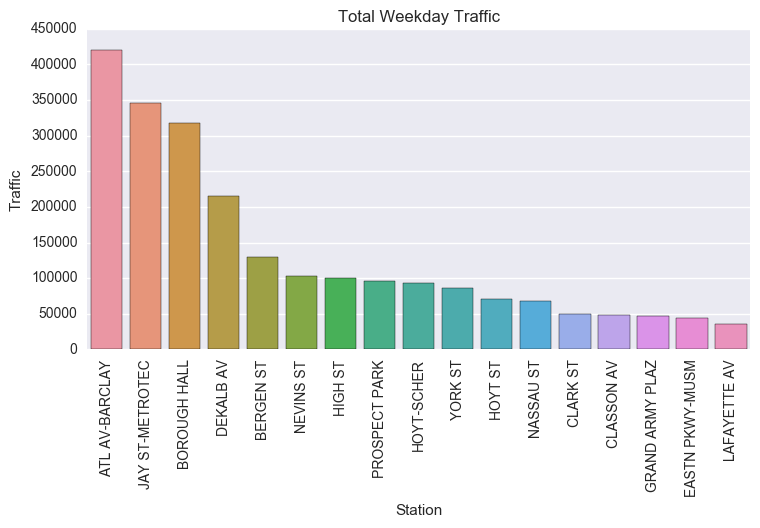

In [77]:
sns.factorplot('station', 'weekly_traffic', data = total_by_station, kind = 'bar', aspect = 2)
plt.xticks(rotation=90)
plt.xlabel('Station')
plt.ylabel('Traffic')
plt.title("Total Weekday Traffic");

In [78]:
top_stations = ['ATL AV-BARCLAY', 'JAY ST-METROTEC', 'BOROUGH HALL', 'DEKALB AV']

In [85]:
stations = potential_stations[potential_stations['station'].isin(top_stations)]

In [98]:
station = potential_stations[potential_stations['station'] == 'ATL AV-BARCLAY']

In [99]:
station = station.groupby(by=['parsed_time'], as_index=False).sum()[['parsed_time', 'hourly_entries', 'hourly_exits', 'traffic']]

In [100]:
times = ['2017-01-22 00:00:00', '2017-01-22 04:00:00', '2017-01-22 08:00:00', '2017-01-22 12:00:00', '2017-01-22 16:00:00', '2017-01-22 20:00:00']
station = station[station['parsed_time'].isin(times)]

In [105]:
station

,parsed_time,hourly_entries,hourly_exits,traffic
0,2017-01-22 00:00:00,161599.0,124045.0,285644.0
1,2017-01-22 04:00:00,18946.0,18074.0,37020.0
4,2017-01-22 08:00:00,158775.0,106967.0,265742.0
15,2017-01-22 12:00:00,330147.0,223133.0,553280.0
16,2017-01-22 16:00:00,277302.0,238839.0,516141.0
17,2017-01-22 20:00:00,353608.0,473083.0,826691.0


In [96]:
station = station.append(station.loc[0])
station.reset_index(drop=True, inplace=True)
station.ix[6, 'parsed_time'] = parse('2017-01-22 23:59:59')
station.ix[0, 'hourly_entries'] = 0
station.ix[0, 'hourly_exits'] = 0
station.ix[0, 'traffic'] = 0

In [97]:
station

,parsed_time,hourly_entries,hourly_exits,traffic
0,2017-01-22 00:00:00,0.0,0.0,0.0
1,2017-01-22 04:00:00,18946.0,18074.0,37020.0
2,2017-01-22 08:00:00,158775.0,106967.0,265742.0
3,2017-01-22 12:00:00,330147.0,223133.0,553280.0
4,2017-01-22 16:00:00,277302.0,238839.0,516141.0
5,2017-01-22 20:00:00,353608.0,473083.0,826691.0
6,2017-01-22 23:59:59,161599.0,124045.0,285644.0


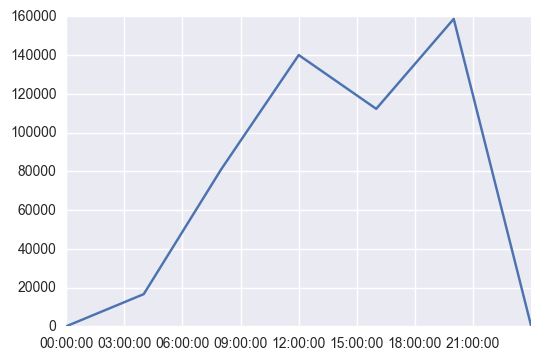

In [84]:
fig = plt.figure()
ax = plt.axes()

#ax.set_xticks(station['parsed_time'])

ax.plot(station['parsed_time'], station['traffic']);